- [9.2.4 - Example: Therapeutic touch](#9.2.4---Example:-Therapeutic-touch)   

## Chapter 9 - Hierarchical Models

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pmc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from IPython.display import Image
from matplotlib import gridspec

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

### 9.2.4 - Example: Therapeutic touch

In [2]:
df = pd.read_csv('data/TherapeuticTouchData.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
y    280 non-null int64
s    280 non-null object
dtypes: int64(1), object(1)
memory usage: 4.5+ KB


#### Figure 9.9

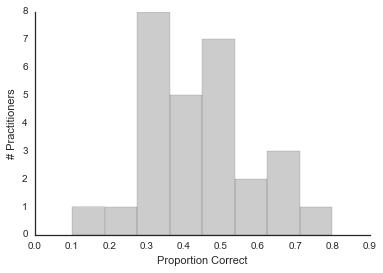

In [3]:
df_proportions = df.groupby('s')['y'].apply(lambda x: x.sum()/len(x))

ax = sns.distplot(df_proportions, bins=8, kde=False, color='gray')
ax.set(xlabel='Proportion Correct', ylabel='# Practitioners')
sns.despine(ax=ax);

#### Model (Kruschke, 2014)

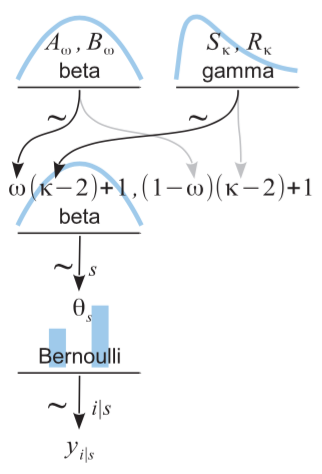

In [4]:
Image('images/fig9_7.png', width=250)

In [5]:
le = preprocessing.LabelEncoder()
practitioner_idx = le.fit_transform(df.s)

practitioner_codes = df.s.unique()
n_practitioners = len(practitioner_codes)

with pmc.Model() as hierarchical_model:
    omega = pmc.Beta('omega', 1, 1)
    kappa = pmc.Gamma('kappa', 0.01, 0.01)+2

    theta = pmc.Beta('theta', omega*(kappa-2)+1, (1-omega)*(kappa-2)+1, shape=n_practitioners)
    
    y = pmc.Bernoulli('y', theta[practitioner_idx], observed=df.y)    

Applied logodds-transform to omega and added transformed omega_logodds_ to model.
Applied log-transform to kappa and added transformed kappa_log_ to model.
Applied logodds-transform to theta and added transformed theta_logodds_ to model.


In [6]:
with hierarchical_model:
    start = pmc.find_MAP()
    step = pmc.NUTS(state=start)
        
    trace= pmc.sample(20000, step, start=start)

 [-----------------100%-----------------] 20000 of 20000 complete in 139.4 sec

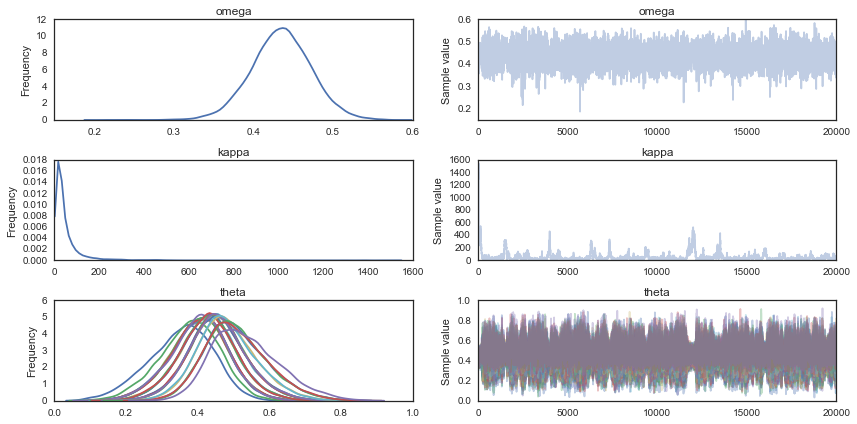

In [7]:
pmc.traceplot(trace);

In [8]:
pmc.df_summary(trace)

                mean         sd  mc_error   hpd_2.5    hpd_97.5
omega       0.434812   0.038094  0.000493  0.361602    0.510868
kappa      50.168995  80.506002  5.958885  1.292963  161.983467
theta__0    0.352225   0.090641  0.003101  0.162095    0.513260
theta__1    0.377883   0.084996  0.002280  0.206118    0.538029
theta__2    0.404022   0.083004  0.001373  0.238927    0.568642
theta__3    0.403210   0.084287  0.001414  0.229836    0.564883
theta__4    0.403735   0.082949  0.001375  0.241482    0.573729
theta__5    0.403631   0.082946  0.001436  0.243330    0.572008
theta__6    0.404174   0.083474  0.001377  0.229084    0.561067
theta__7    0.403308   0.083154  0.001433  0.232579    0.563955
theta__8    0.404079   0.083160  0.001420  0.228022    0.560791
theta__9    0.403795   0.082995  0.001443  0.232439    0.562801
theta__10   0.429370   0.083258  0.000672  0.256850    0.593525
theta__11   0.429771   0.082238  0.000645  0.267162    0.597936
theta__12   0.429914   0.081918  0.00067

#### Marginal posterior distributions (PyMC3)

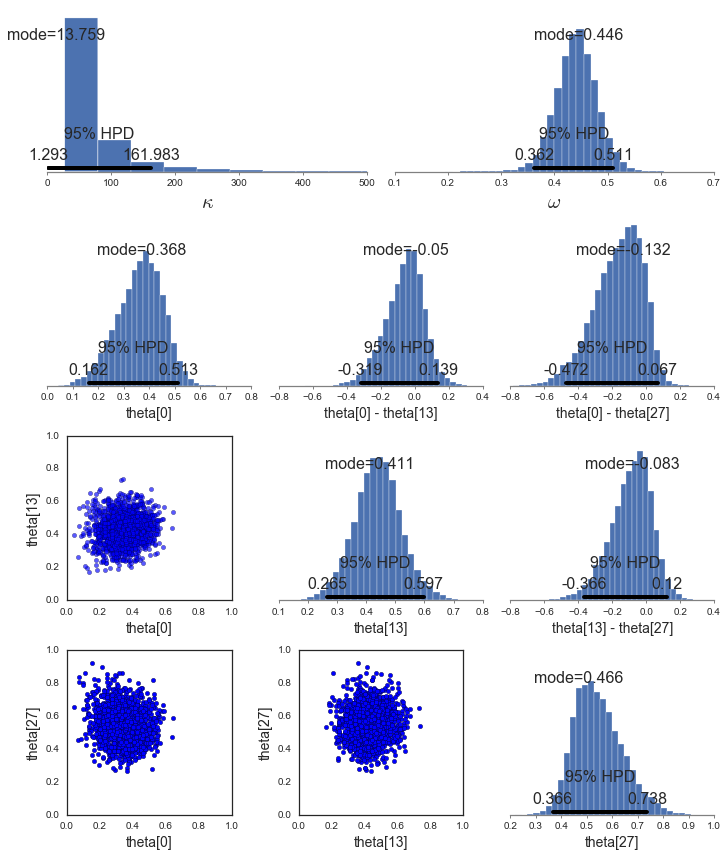

In [9]:
plt.figure(figsize=(10,12))

# Define gridspec
gs = gridspec.GridSpec(4, 6)
ax1 = plt.subplot(gs[0,:3])
ax2 = plt.subplot(gs[0,3:])
ax3 = plt.subplot(gs[1,:2])
ax4 = plt.subplot(gs[1,2:4])
ax5 = plt.subplot(gs[1,4:6])
ax6 = plt.subplot(gs[2,:2])                     
ax7 = plt.subplot(gs[2,2:4])
ax8 = plt.subplot(gs[2,4:6])
ax9 = plt.subplot(gs[3,:2])
ax10 = plt.subplot(gs[3,2:4])
ax11 = plt.subplot(gs[3,4:6])

font_d = {'size':14}

# kappa posterior plot
pmc.plot_posterior(trace['kappa'], point_estimate='mode', ax=ax1)
ax1.set(xlim=(0,500))
ax1.set_xlabel('$\kappa$', fontdict={'size':20, 'weight':'bold'})

# omega posterior plot
pmc.plot_posterior(trace['omega'], point_estimate='mode', ax=ax2)
ax2.set_xlabel('$\omega$', fontdict={'size':20, 'weight':'bold'})

# theta posterior plots
pmc.plot_posterior(trace['theta'][:,0], point_estimate='mode', ax=ax3)
ax3.set_xlabel('theta[0]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,13], point_estimate='mode', ax=ax7)
ax7.set_xlabel('theta[13]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,27], point_estimate='mode', ax=ax11)
ax11.set_xlabel('theta[27]', fontdict=font_d)

# theta scatter plots
ax6.scatter(trace['theta'][::10,0], trace['theta'][::10,13], alpha=0.65)
ax6.set_xlabel('theta[0]', fontdict=font_d)
ax6.set_ylabel('theta[13]', fontdict=font_d)

ax9.scatter(trace['theta'][::10,0], trace['theta'][::10,27])
ax9.set_xlabel('theta[0]', fontdict=font_d)
ax9.set_ylabel('theta[27]', fontdict=font_d)

ax10.scatter(trace['theta'][::10,13], trace['theta'][::10,27])
ax10.set_xlabel('theta[13]', fontdict=font_d)
ax10.set_ylabel('theta[27]', fontdict=font_d)

for ax in [ax6, ax9, ax10]:
    ax.set(xlim=(0,1), ylim=(0,1), aspect='equal') 
    
# theta posterior differences plots
pmc.plot_posterior(trace['theta'][:,0]-trace['theta'][:,14], point_estimate='mode', ax=ax4)
ax4.set_xlabel('theta[0] - theta[13]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,0]-trace['theta'][:,27], point_estimate='mode', ax=ax5)
ax5.set_xlabel('theta[0] - theta[27]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,13]-trace['theta'][:,27], point_estimate='mode', ax=ax8)
ax8.set_xlabel('theta[13] - theta[27]', fontdict=font_d)

plt.tight_layout();

#### Marginal posterior distributions (Kruschke, 2014)

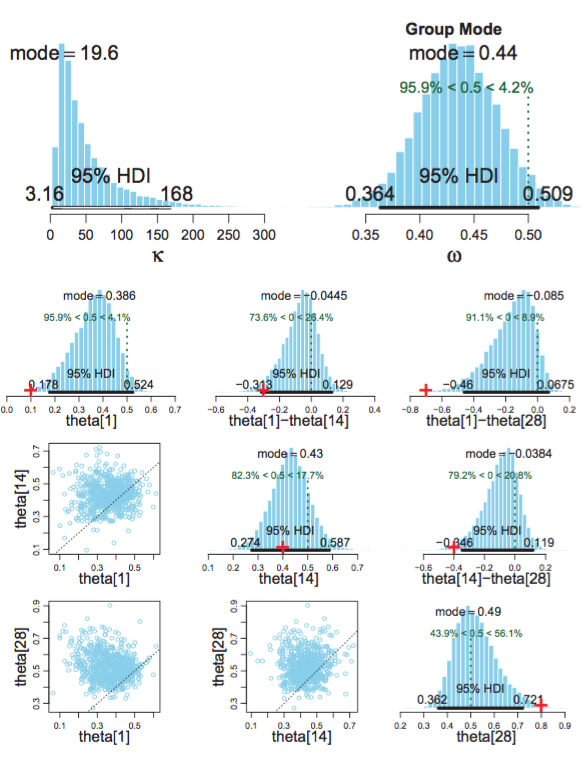

In [10]:
Image('images/fig9_10.png')